# **2.Classification Using CNN**

## 2.1.Data Loading and Preprocessing

In [1]:
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [2]:
def load_mnist_data(data_dir):
    data_splits = ['train', 'val', 'test']
    data = {}

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ])

    for split in data_splits:
        images = []
        labels = []

        split_dir = os.path.join(data_dir, split)

        for folder in os.listdir(split_dir):
            folder_path = os.path.join(split_dir, folder)
            num_digits = 0 if folder == '0' else len(folder)

            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)

                image = Image.open(img_path).convert('L')
                image_tensor = transform(image)

                images.append(image_tensor)
                labels.append(num_digits)

        data[split] = (torch.stack(images), torch.tensor(labels))

    return data


In [3]:
class MultiMNISTDataset(Dataset):
    def __init__(self, images_tensor, labels_tensor):
        self.images_tensor = images_tensor
        self.labels_tensor = labels_tensor

    def __len__(self):
        return self.images_tensor.size(0)

    def __getitem__(self, idx):
        image = self.images_tensor[idx]
        label = self.labels_tensor[idx]
        return image, label

In [4]:
def create_dataloader(images, labels, batch_size, shuffle=True):
    dataset = MultiMNISTDataset(images, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2, pin_memory=True)
    return dataloader

In [5]:
data_dir = "../../data/external/double_mnist"

In [6]:
mnist_data = load_mnist_data(data_dir)

In [7]:
batch_size = 32

train_loader = create_dataloader(mnist_data['train'][0], mnist_data['train'][1], batch_size)
val_loader = create_dataloader(mnist_data['val'][0], mnist_data['val'][1], batch_size, shuffle=False)
test_loader = create_dataloader(mnist_data['test'][0], mnist_data['test'][1], batch_size, shuffle=False)

## 2.2.Implement the CNN Class

In [8]:
import sys
sys.path.append("../..")

import models.cnn.cnn as cnn

## 2.3.Hyperparameter Tuning

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [10]:
hyperparams = [
    {'lr': 0.001, 'dropout': 0.5, 'num_conv_layers': 3, 'optimizer': 'Adam'},
    {'lr': 0.0001, 'dropout': 0.3, 'num_conv_layers': 4, 'optimizer': 'SGD'},
    {'lr': 0.01, 'dropout': 0.7, 'num_conv_layers': 5, 'optimizer': 'RMSprop'},
    {'lr': 0.01, 'dropout': 0.3, 'num_conv_layers': 3, 'optimizer': 'SGD'},
    {'lr': 0.001, 'dropout': 0.5, 'num_conv_layers': 4, 'optimizer': 'RMSprop'},
    {'lr': 0.001, 'dropout': 0.7, 'num_conv_layers': 5, 'optimizer': 'Adam'},
]

In [11]:
def get_optimizer(optimizer_name, params, lr):
    if optimizer_name == 'Adam':
        return optim.Adam(params, lr=lr)
    elif optimizer_name == 'SGD':
        return optim.SGD(params, lr=lr, momentum=0.9)
    elif optimizer_name == 'RMSprop':
        return optim.RMSprop(params, lr=lr)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [14]:
results = []

for tsk in ['regression', 'classification']:
    for i, hp in enumerate(hyperparams):
        print(f"Training with hyperparameters {hp}")

        model = cnn.CNN(task=tsk, num_classes=4, input_channels=1, num_conv_layers=hp['num_conv_layers'], dropout=hp['dropout']).to(device)

        if tsk == 'classification':
            criterion = nn.CrossEntropyLoss()
        elif tsk == 'regression':
            criterion = nn.MSELoss()

        optimizer = get_optimizer(hp['optimizer'], model.parameters(), hp['lr'])

        num_epochs = 20

        train_losses = torch.zeros(num_epochs)
        val_losses = torch.zeros(num_epochs)

        for epoch in range(num_epochs):
            model.train()

            running_loss = 0.0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs, _ = model(inputs)

                if tsk == 'regression':
                    outputs = outputs.squeeze(-1).float()
                    labels = labels.float() 

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            train_losses[epoch] = running_loss / len(train_loader)

            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs, _ = model(inputs)

                    if tsk == 'regression':
                        outputs = outputs.squeeze(-1).float()
                        labels = labels.float() 

                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
            val_losses[epoch] = val_loss / len(val_loader)

        results.append({
            'hyperparams': hp,
            'train_losses': train_losses,
            'val_losses': val_losses
        })

Training with hyperparameters {'lr': 0.001, 'dropout': 0.5, 'num_conv_layers': 3, 'optimizer': 'Adam'}
Training with hyperparameters {'lr': 0.0001, 'dropout': 0.3, 'num_conv_layers': 4, 'optimizer': 'SGD'}
Training with hyperparameters {'lr': 0.01, 'dropout': 0.7, 'num_conv_layers': 5, 'optimizer': 'RMSprop'}
Training with hyperparameters {'lr': 0.01, 'dropout': 0.3, 'num_conv_layers': 3, 'optimizer': 'SGD'}
Training with hyperparameters {'lr': 0.001, 'dropout': 0.5, 'num_conv_layers': 4, 'optimizer': 'RMSprop'}
Training with hyperparameters {'lr': 0.001, 'dropout': 0.7, 'num_conv_layers': 5, 'optimizer': 'Adam'}
Training with hyperparameters {'lr': 0.001, 'dropout': 0.5, 'num_conv_layers': 3, 'optimizer': 'Adam'}
Training with hyperparameters {'lr': 0.0001, 'dropout': 0.3, 'num_conv_layers': 4, 'optimizer': 'SGD'}
Training with hyperparameters {'lr': 0.01, 'dropout': 0.7, 'num_conv_layers': 5, 'optimizer': 'RMSprop'}
Training with hyperparameters {'lr': 0.01, 'dropout': 0.3, 'num_conv

type : Regression , hyperparameters : {'lr': 0.001, 'dropout': 0.5, 'num_conv_layers': 3, 'optimizer': 'Adam'} ,validation loss: tensor(0.6896)
type : Regression , hyperparameters : {'lr': 0.0001, 'dropout': 0.3, 'num_conv_layers': 4, 'optimizer': 'SGD'} ,validation loss: tensor(0.0388)
type : Regression , hyperparameters : {'lr': 0.01, 'dropout': 0.7, 'num_conv_layers': 5, 'optimizer': 'RMSprop'} ,validation loss: tensor(0.0186)
type : Regression , hyperparameters : {'lr': 0.01, 'dropout': 0.3, 'num_conv_layers': 3, 'optimizer': 'SGD'} ,validation loss: tensor(0.0006)
type : Regression , hyperparameters : {'lr': 0.001, 'dropout': 0.5, 'num_conv_layers': 4, 'optimizer': 'RMSprop'} ,validation loss: tensor(0.4080)
type : Regression , hyperparameters : {'lr': 0.001, 'dropout': 0.7, 'num_conv_layers': 5, 'optimizer': 'Adam'} ,validation loss: tensor(1.8641)
type : Classification , hyperparameters : {'lr': 0.001, 'dropout': 0.5, 'num_conv_layers': 3, 'optimizer': 'Adam'} ,validation loss: 

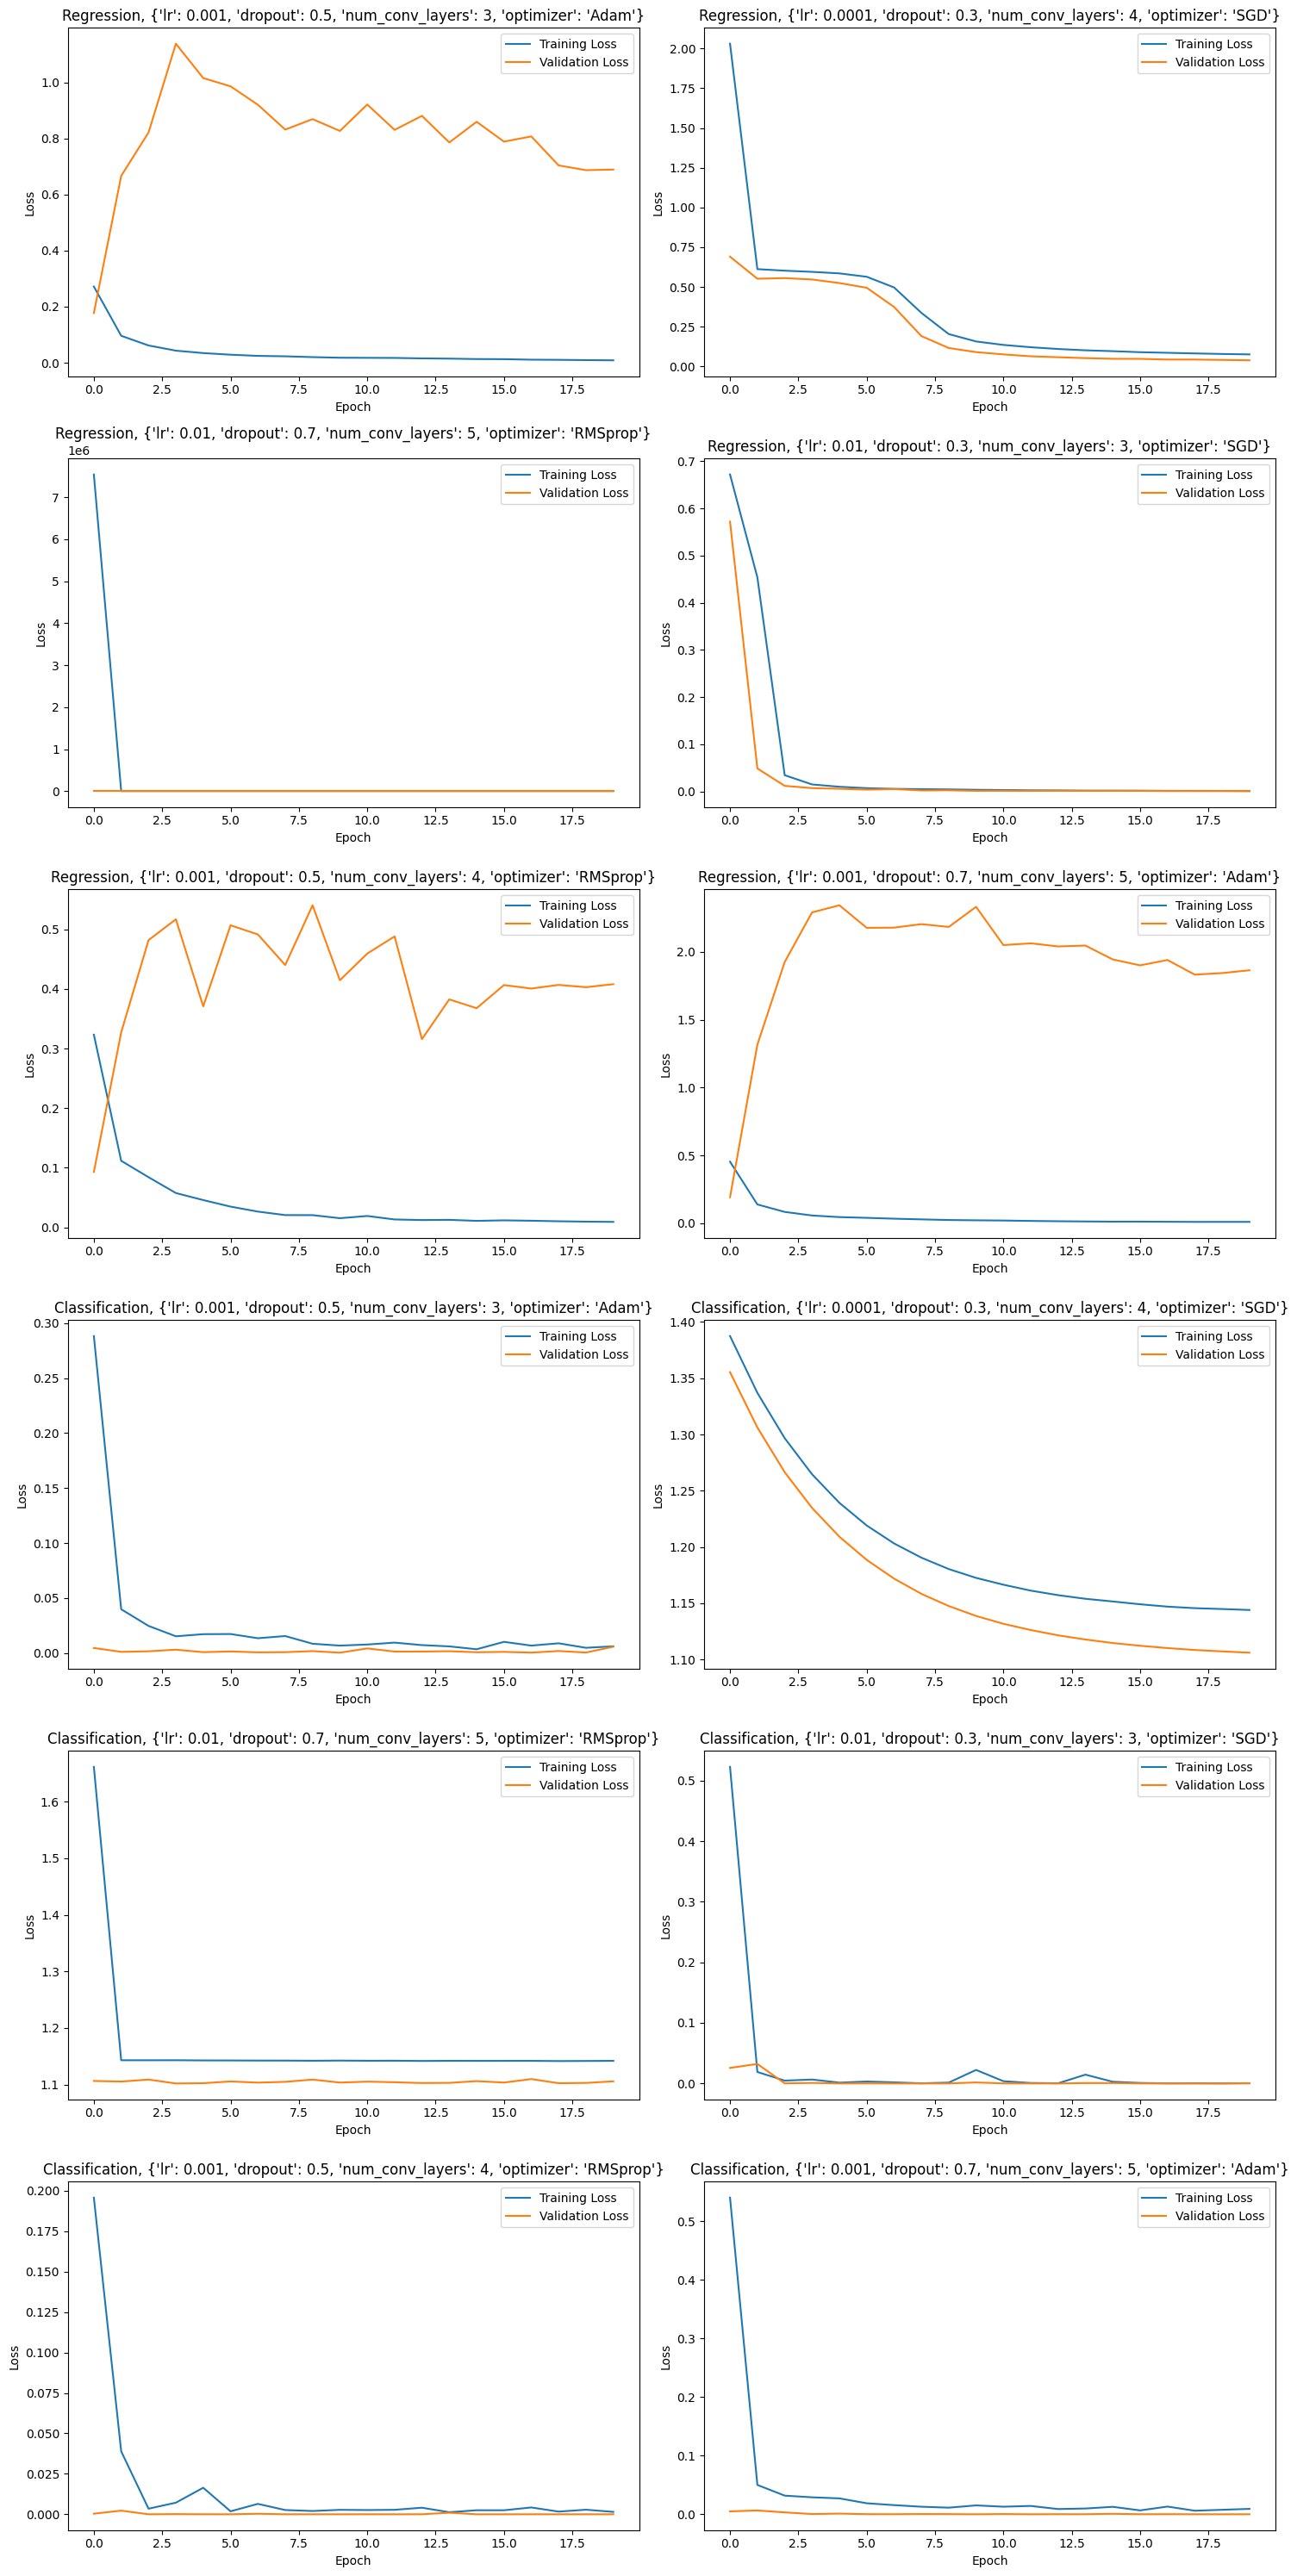

In [27]:
num_plots = len(results)
cols = 2
rows = (num_plots + cols - 1) // cols

fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 5))
axs = axs.flatten()

for i, result in enumerate(results):
    axs[i].plot(result['train_losses'], label='Training Loss')
    axs[i].plot(result['val_losses'], label='Validation Loss')
    hp = result['hyperparams']
    type = 'Classification' if i >= 6 else 'Regression'
    axs[i].set_title(f'{type}, {hp}')
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    print('type :', type,', hyperparameters :', result['hyperparams'], ",validation loss:", result['val_losses'][-1])
    axs[i].legend()

for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

best models according to validation loss:

type : Regression , hyperparameters : {'lr': 0.01, 'dropout': 0.3, 'num_conv_layers': 3, 'optimizer': 'SGD'} ,validation loss: tensor(0.0006)

type : Classification , hyperparameters : {'lr': 0.001, 'dropout': 0.5, 'num_conv_layers': 4, 'optimizer': 'RMSprop'} ,validation loss: tensor(7.3939e-07)

In [29]:
configurations = [
    ({'lr': 0.01, 'dropout': 0.3, 'num_conv_layers': 3, 'optimizer': 'SGD'}, 'regression'),
    ({'lr': 0.001, 'dropout': 0.5, 'num_conv_layers': 4, 'optimizer': 'RMSprop'}, 'classification'),
]

In [34]:
results = []

for config, task in configurations:
    print(f"Training and evaluating configuration {config} for task: {task}")

    model = cnn.CNN(task=task, num_classes=4, input_channels=1, num_conv_layers=config['num_conv_layers']).to(device)

    if task == 'classification':
        criterion = nn.CrossEntropyLoss()
    elif task == 'regression':
        criterion = nn.MSELoss()

    optimizer = get_optimizer(config['optimizer'], model.parameters(), config['lr'])
    
    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs, _ = model(inputs)
            if task == 'regression':
                outputs = outputs.squeeze(-1).float()
                labels = labels.float() 

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

    for phase, loader in [('Validation', val_loader), ('Test', test_loader)]:
        correct = 0
        total = 0
        cumulative_loss = 0.0

        model.eval()
        with torch.no_grad():
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs, _ = model(inputs)

                if task == 'regression':
                    outputs = outputs.squeeze(-1).float()
                    labels = labels.float() 

                loss = criterion(outputs, labels)
                
                cumulative_loss += loss.item()
                if task == 'classification':
                    _, predicted = torch.max(outputs, 1)
                    correct += (predicted == labels).sum().item()
                total += labels.size(0)

        avg_loss = cumulative_loss / len(loader)
        if task == 'classification':
            accuracy = correct / total * 100
            print(f"{phase} Accuracy: {accuracy:.2f}%, {phase} Loss: {avg_loss:.4f}")
        else:
            mse = avg_loss
            print(f"{phase} MSE: {mse:.4f}, {phase} Loss: {avg_loss:.4f}")
        
        results.append({
            'configuration': config,
            'task': task,
            'phase': phase,
            'score': accuracy if task == 'classification' else mse,
            'loss': avg_loss
        })


Training and evaluating configuration {'lr': 0.01, 'dropout': 0.3, 'num_conv_layers': 3, 'optimizer': 'SGD'} for task: regression


Epoch 1/20, Loss: 0.3156
Epoch 2/20, Loss: 0.0602
Epoch 3/20, Loss: 0.0259
Epoch 4/20, Loss: 0.0186
Epoch 5/20, Loss: 0.0161
Epoch 6/20, Loss: 0.0135
Epoch 7/20, Loss: 0.0138
Epoch 8/20, Loss: 0.0121
Epoch 9/20, Loss: 0.0114
Epoch 10/20, Loss: 0.0104
Epoch 11/20, Loss: 0.0091
Epoch 12/20, Loss: 0.0084
Epoch 13/20, Loss: 0.0076
Epoch 14/20, Loss: 0.0064
Epoch 15/20, Loss: 0.0055
Epoch 16/20, Loss: 0.0036
Epoch 17/20, Loss: 0.0028
Epoch 18/20, Loss: 0.0022
Epoch 19/20, Loss: 0.0015
Epoch 20/20, Loss: 0.0016
Validation MSE: 0.0022, Validation Loss: 0.0022
Test MSE: 0.0017, Test Loss: 0.0017
Training and evaluating configuration {'lr': 0.001, 'dropout': 0.5, 'num_conv_layers': 4, 'optimizer': 'RMSprop'} for task: classification
Epoch 1/20, Loss: 0.1355
Epoch 2/20, Loss: 0.0110
Epoch 3/20, Loss: 0.0195
Epoch 4/20, Loss: 0.0033
Epoch 5/20, Loss: 0.0030
Epoch 6/20, Loss: 0.0025
Epoch 7/20, Loss: 0.0030
Epoch 8/20, Loss: 0.0036
Epoch 9/20, Loss: 0.0026
Epoch 10/20, Loss: 0.0021
Epoch 11/20, Lo

best models:

type : Regression , hyperparameters : {'lr': 0.01, 'dropout': 0.3, 'num_conv_layers': 3, 'optimizer': 'SGD'} ,validation loss: tensor(0.0006)

Validation MSE: 0.0022, Validation Loss: 0.0022
Test MSE: 0.0017, Test Loss: 0.0017

type : Classification , hyperparameters : {'lr': 0.001, 'dropout': 0.5, 'num_conv_layers': 4, 'optimizer': 'RMSprop'} ,validation loss: tensor(7.3939e-07)

Validation Accuracy: 100.00%, Validation Loss: 0.0000
Test Accuracy: 100.00%, Test Loss: 0.0000

## 2.4.Feature map Visualization

In [16]:
import matplotlib.pyplot as plt

In [21]:
def visualize_feature_maps(feature_maps, image_idx=0, num_filters=6):

    num_layers = len(feature_maps)
    plt.figure(figsize=(15, num_layers * 3))

    for i, fmap in enumerate(feature_maps):
        fmap_image = fmap[image_idx].detach().cpu()
        num_channels = fmap_image.size(0)

        for j in range(min(num_filters, num_channels)):
            plt.subplot(num_layers, num_filters, i * num_filters + j + 1)
            plt.imshow(fmap_image[j].numpy(), cmap='gray')
            plt.axis('off')
            
    plt.suptitle(f"Visualization of Feature Maps (Max {num_filters} Filters per Layer shown)", fontsize=16)
    plt.tight_layout()
    plt.show()


In [18]:
import os
from PIL import Image
import torchvision.transforms as transforms

In [19]:
image_paths = [
    os.path.join(data_dir, "test", "2", "0_2.png"),
    os.path.join(data_dir, "test", "016", "0_016.png"),
    os.path.join(data_dir, "test", "67", "0_67.png"),
]

transform = transforms.Compose([
    transforms.ToTensor(),
])

image_tensors = []
for path in image_paths:
    image = Image.open(path)
    image_tensor = transform(image)
    image_tensors.append(image_tensor)

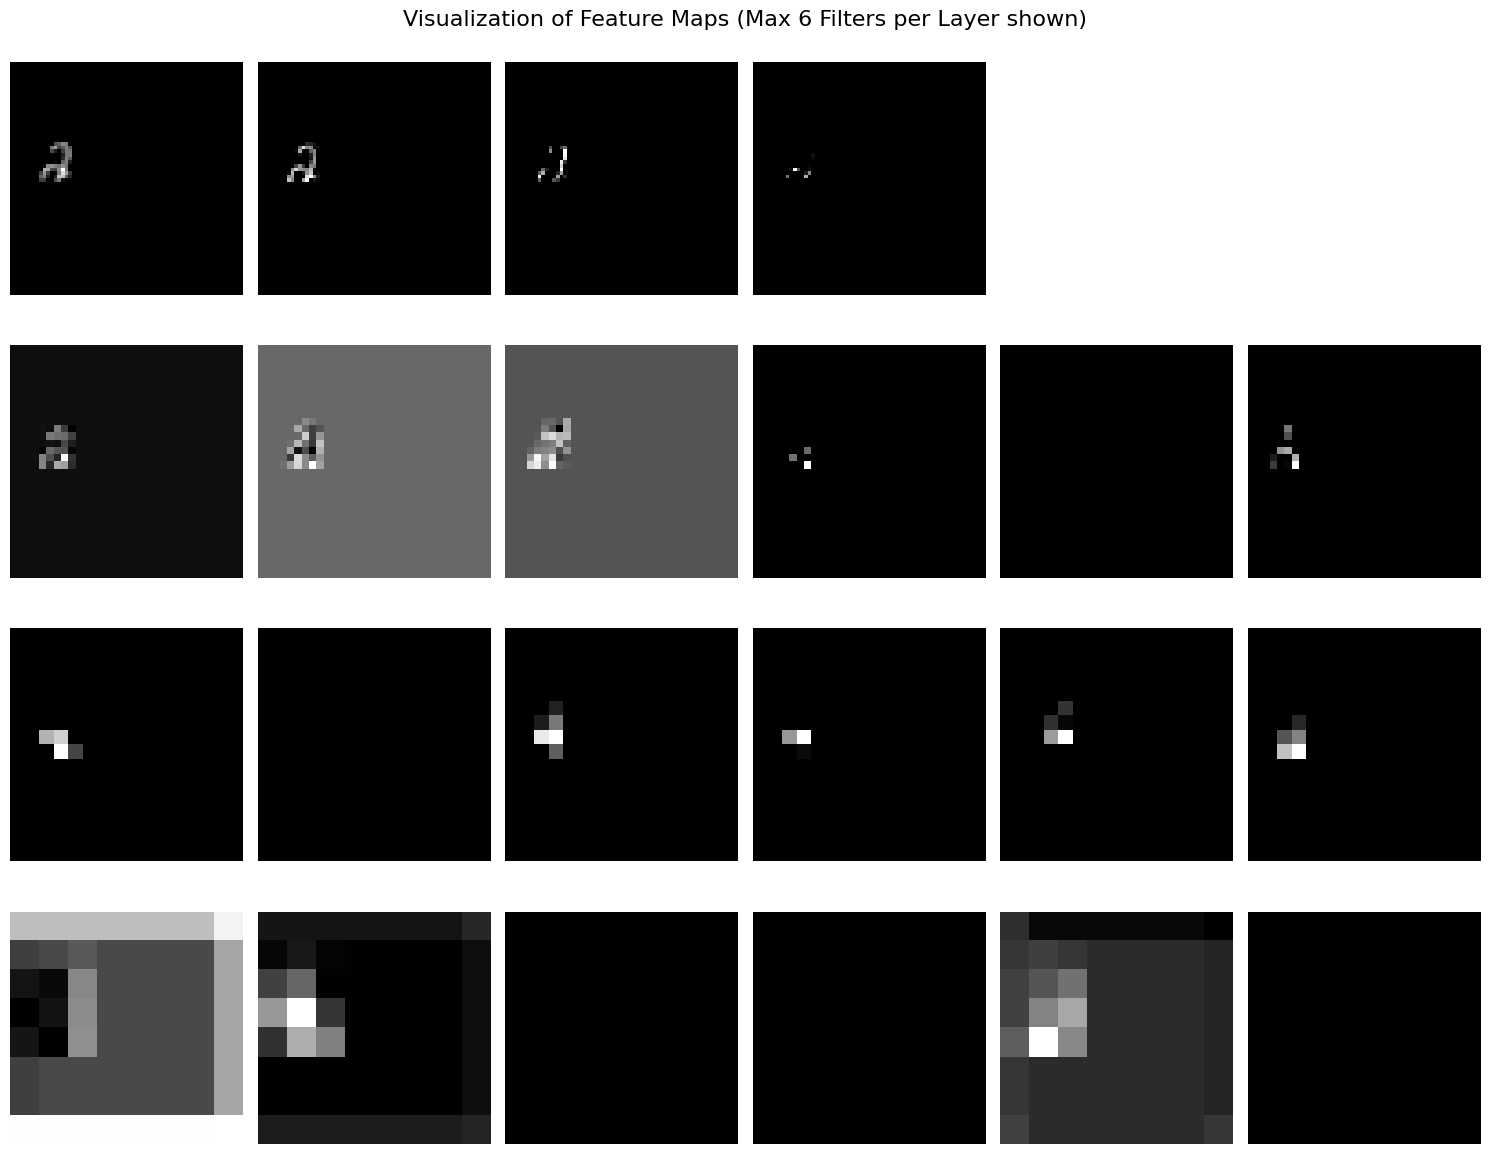

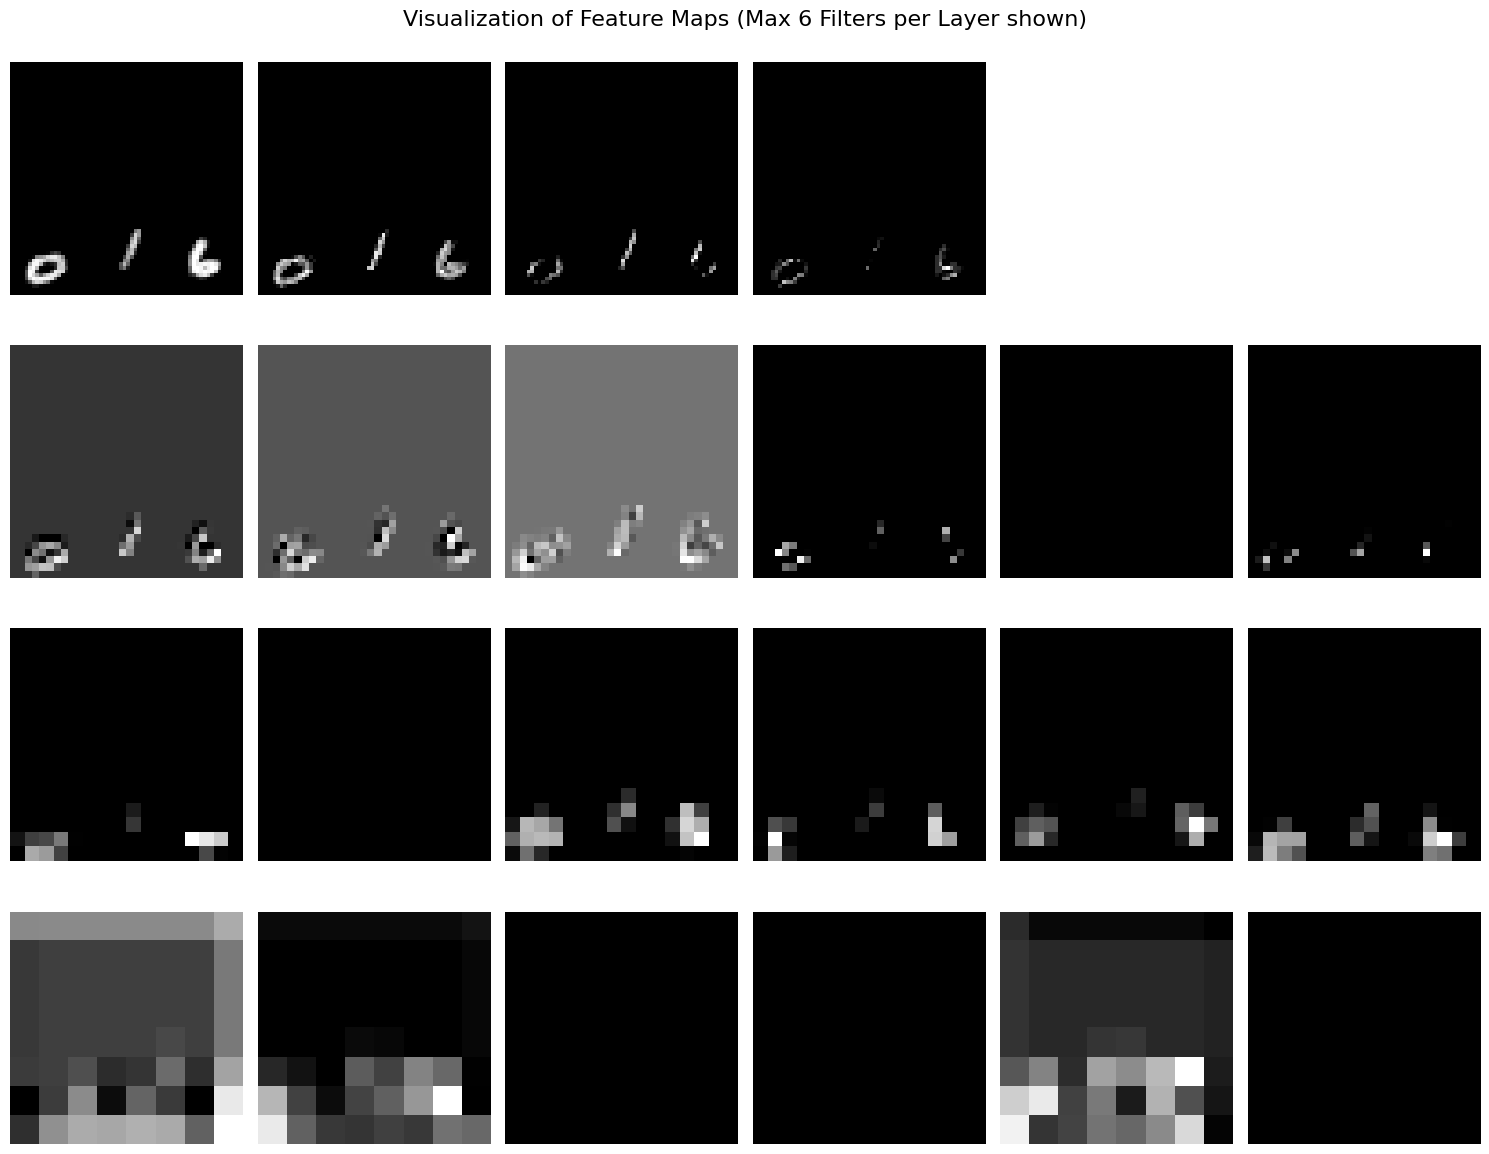

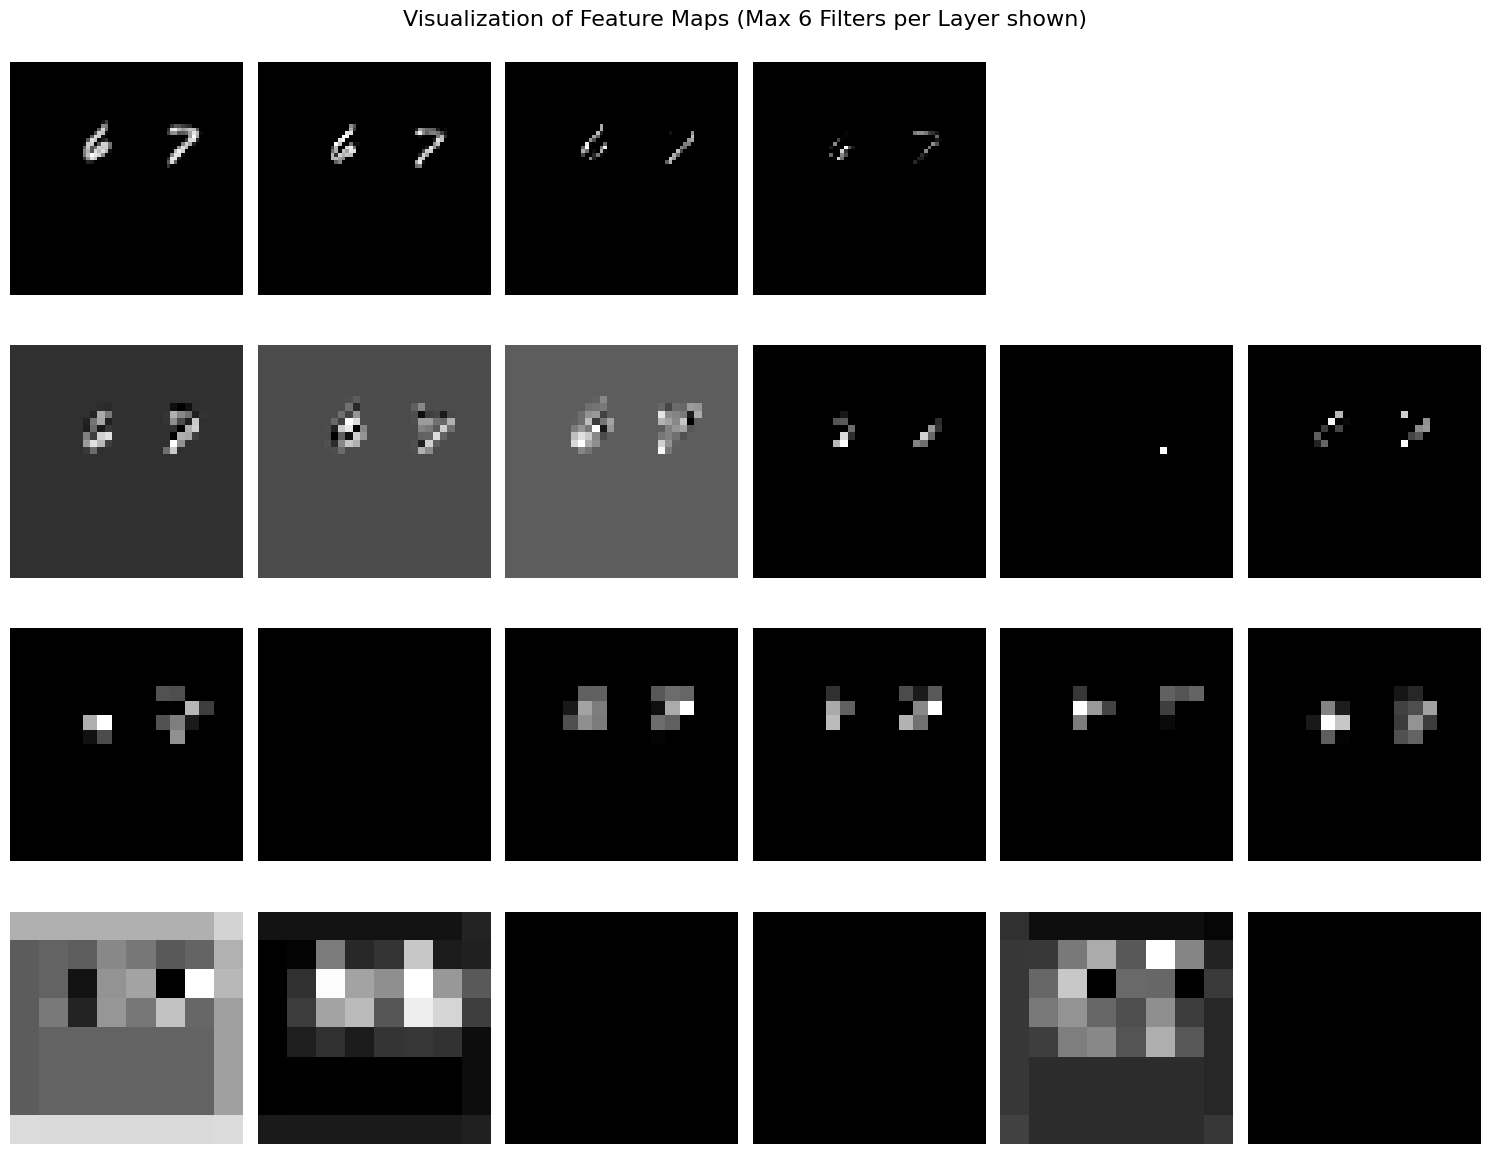

In [23]:
model = cnn.CNN(task='classification', num_classes=4, input_channels=1, num_conv_layers=4, dropout=0.5).to(device)

for image_tensor in image_tensors:
    image_tensor = image_tensor.to(device)

    outputs, feature_maps = model(image_tensor.unsqueeze(0))

    visualize_feature_maps(feature_maps, image_idx=0, num_filters=6)

starting layers detect edges, intermediate layers identify digit parts, final or last layers recognize digits

# **3.Multi Label Classification**

## 3.1.Data Loading and Preprocessing

In [1]:
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [2]:
def load_mnist_data(data_dir):
    data_splits = ['train', 'val', 'test']
    data = {}
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    for split in data_splits:
        images = []
        labels = []
        split_dir = os.path.join(data_dir, split)

        for folder_name in os.listdir(split_dir):
            label = folder_name if folder_name != '0' else ''
            folder_path = os.path.join(split_dir, folder_name)

            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)

                image = Image.open(img_path).convert('L')
                image_tensor = transform(image)
                images.append(image_tensor)

                label_tensor = one_hot_encode_label(label)
                labels.append(label_tensor)

        data[split] = (torch.stack(images), torch.stack(labels))

    return data

def one_hot_encode_label(label, num_classes=10, max_digits=4):
    one_hot_tensor = torch.zeros((max_digits, num_classes))
    for i, digit in enumerate(label[:max_digits]):
        one_hot_tensor[i, int(digit)] = 1
    return one_hot_tensor


In [3]:
class MultiMNISTDataset(Dataset):
    def __init__(self, images_tensor, labels_tensor):
        self.images_tensor = images_tensor
        self.labels_tensor = labels_tensor

    def __len__(self):
        return self.images_tensor.size(0)

    def __getitem__(self, idx):
        image = self.images_tensor[idx]
        label = self.labels_tensor[idx]
        return image, label


In [4]:
def create_dataloader(images, labels, batch_size, shuffle=True):
    dataset = MultiMNISTDataset(images, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2, pin_memory=True)
    
    return dataloader

In [5]:
data_dir = "../../data/external/double_mnist"

mnist_data = load_mnist_data(data_dir)

In [6]:
batch_size = 32

train_loader = create_dataloader(mnist_data['train'][0], mnist_data['train'][1], batch_size)
val_loader = create_dataloader(mnist_data['val'][0], mnist_data['val'][1], batch_size, shuffle=False)
test_loader = create_dataloader(mnist_data['test'][0], mnist_data['test'][1], batch_size, shuffle=False)

## 3.2.Implement the MultiLabelCNN Class

In [7]:
import sys
sys.path.append("../..")

import models.cnn.multilabel_cnn as multicnn

## 3.3.Hyperparameter Tuning

In [8]:
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn

In [9]:
hyperparameters = [
    {'lr': 0.001, 'dropout': 0.5, 'num_conv_layers': 3, 'optimizer': 'Adam', 'epochs': 15},
    {'lr': 0.0001, 'dropout': 0.3, 'num_conv_layers': 4, 'optimizer': 'SGD', 'epochs': 20},
    {'lr': 0.01, 'dropout': 0.7, 'num_conv_layers': 5, 'optimizer': 'RMSprop', 'epochs': 25},
    {'lr': 0.01, 'dropout': 0.3, 'num_conv_layers': 3, 'optimizer': 'SGD', 'epochs': 15},
    {'lr': 0.001, 'dropout': 0.5, 'num_conv_layers': 4, 'optimizer': 'RMSprop', 'epochs': 20},
    {'lr': 0.001, 'dropout': 0.7, 'num_conv_layers': 5, 'optimizer': 'Adam', 'epochs': 25},
]


In [10]:
def get_optimizer(optimizer_name, params, lr):
    if optimizer_name == 'Adam':
        return optim.Adam(params, lr=lr)
    elif optimizer_name == 'SGD':
        return optim.SGD(params, lr=lr, momentum=0.9)
    elif optimizer_name == 'RMSprop':
        return optim.RMSprop(params, lr=lr)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [12]:
results = {}
for i, config in enumerate(hyperparameters):
    print(f"Training Configuration {i+1}: {config}")

    model = multicnn.MultiDigitCNN(num_conv_layers=config["num_conv_layers"], dropout=config["dropout"]).to(device)
    optimizer = get_optimizer(config["optimizer"], model.parameters(), lr=config["lr"])
    criterion = nn.CrossEntropyLoss()
    
    training_losses = []
    validation_losses = []

    for epoch in range(config["epochs"]):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.argmax(dim=2).to(device)
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = sum(criterion(outputs[:, i, :], labels[:, i]) for i in range(model.max_digits)) / model.max_digits
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        training_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.argmax(dim=2).to(device)
                outputs = model(images)
                loss = sum(criterion(outputs[:, i, :], labels[:, i]) for i in range(model.max_digits)) / model.max_digits
                val_loss += loss.item()
        
        validation_losses.append(val_loss / len(val_loader))

    
    results[f"Config {i+1}"] = {"train_loss": training_losses, "val_loss": validation_losses}
    print(f"Training Loss: {training_losses[-1]}, Validation Loss: {validation_losses[-1]}")


Training Configuration 1: {'lr': 0.001, 'dropout': 0.5, 'num_conv_layers': 3, 'optimizer': 'Adam', 'epochs': 15}
Training Loss: 0.8928016558819011, Validation Loss: 1.2967568661291555
Training Configuration 2: {'lr': 0.0001, 'dropout': 0.3, 'num_conv_layers': 4, 'optimizer': 'SGD', 'epochs': 20}
Training Loss: 1.3712923907991594, Validation Loss: 1.3987193190036935
Training Configuration 3: {'lr': 0.01, 'dropout': 0.7, 'num_conv_layers': 5, 'optimizer': 'RMSprop', 'epochs': 25}
Training Loss: 1.3619374402888536, Validation Loss: 1.394031747858575
Training Configuration 4: {'lr': 0.01, 'dropout': 0.3, 'num_conv_layers': 3, 'optimizer': 'SGD', 'epochs': 15}
Training Loss: 0.837232600613899, Validation Loss: 1.3709508623690048
Training Configuration 5: {'lr': 0.001, 'dropout': 0.5, 'num_conv_layers': 4, 'optimizer': 'RMSprop', 'epochs': 20}
Training Loss: 0.6119067566043834, Validation Loss: 1.245169963291346
Training Configuration 6: {'lr': 0.001, 'dropout': 0.7, 'num_conv_layers': 5, 'o

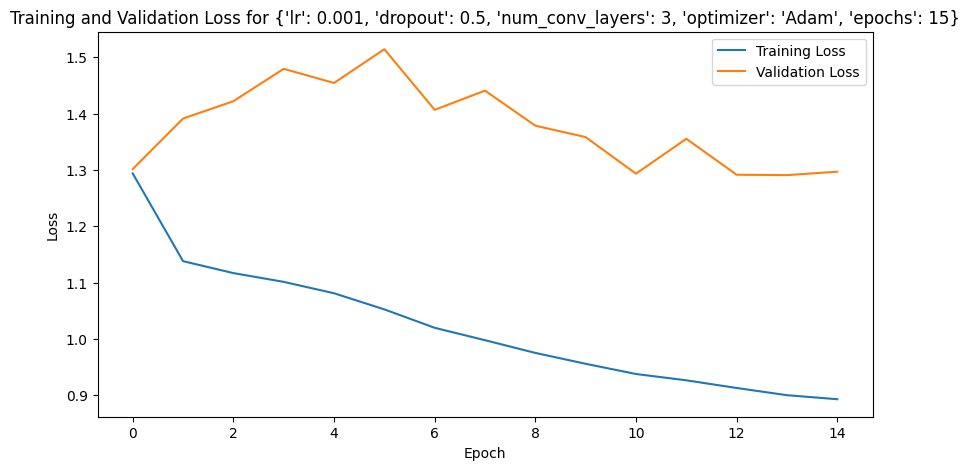

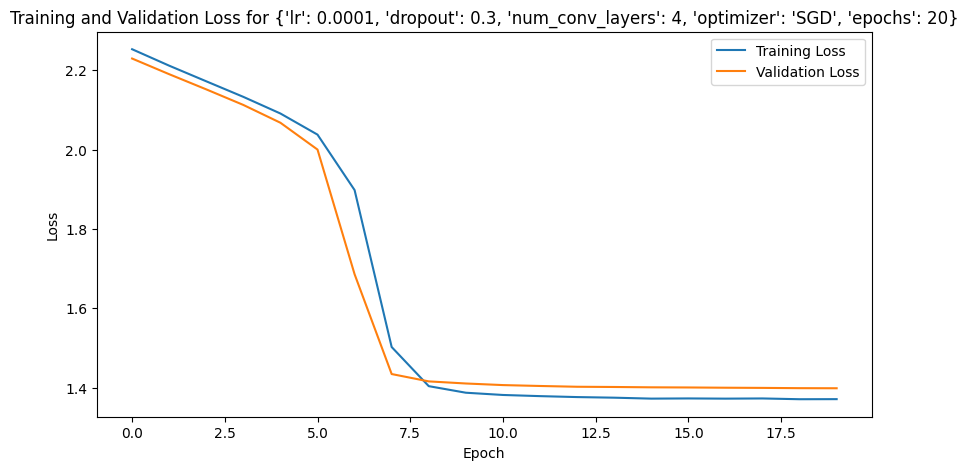

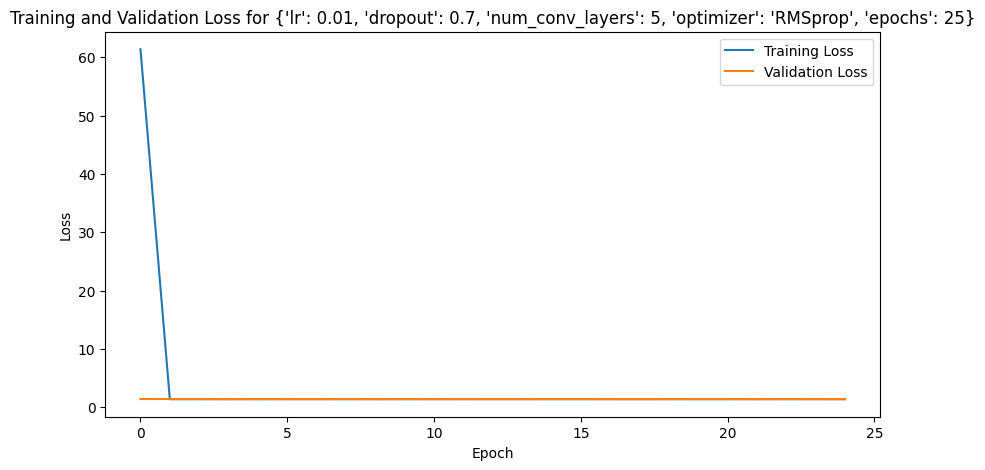

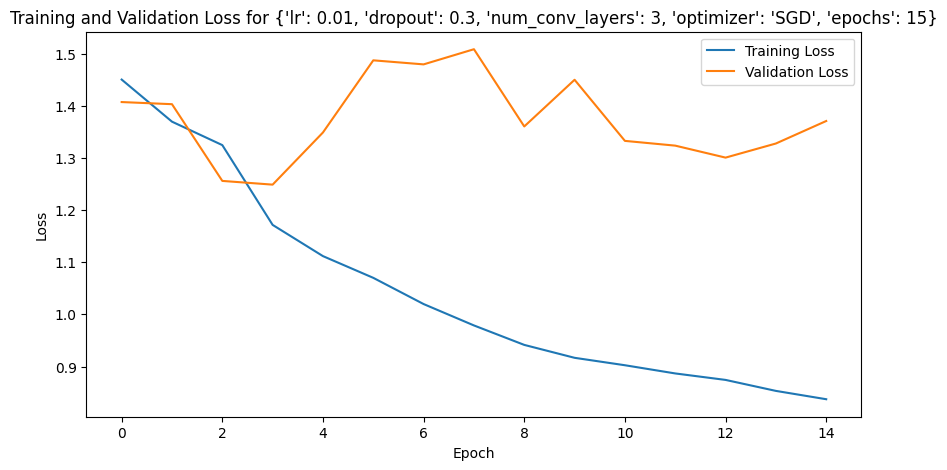

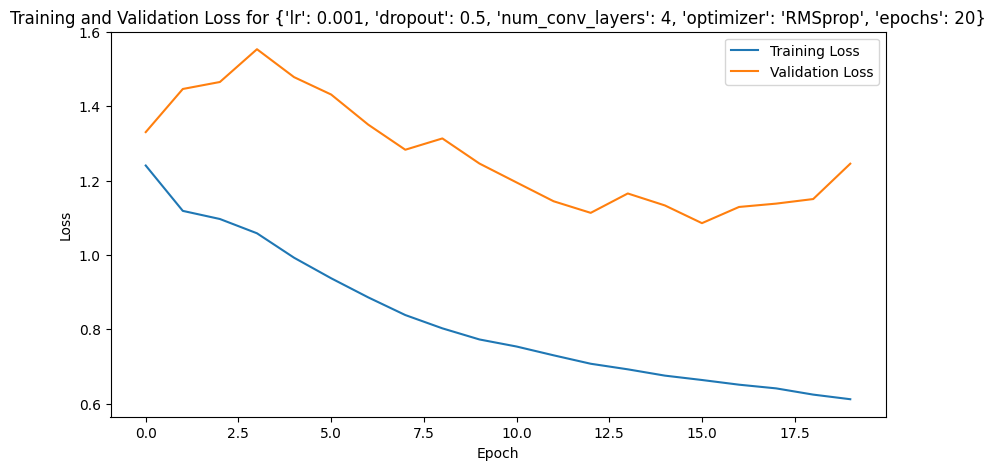

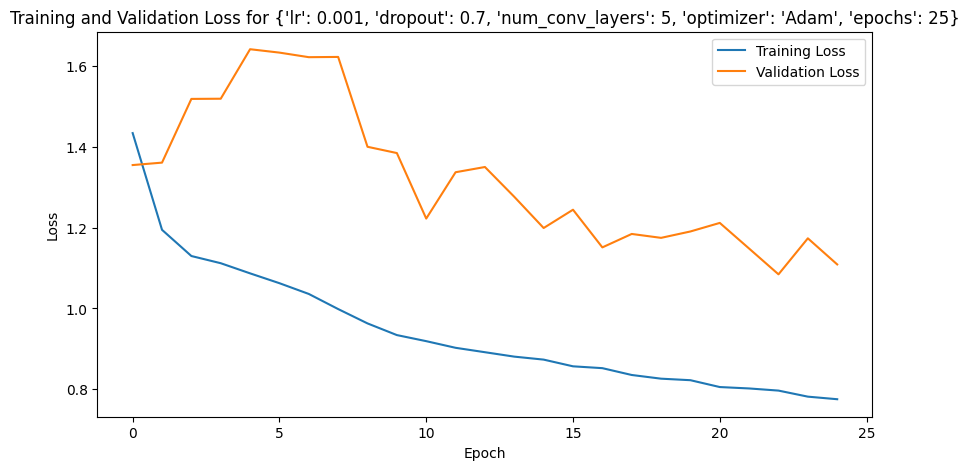

In [13]:
for i, config in enumerate(hyperparameters):
    plt.figure(figsize=(10, 5))
    plt.plot(results[f"Config {i+1}"]["train_loss"], label="Training Loss")
    plt.plot(results[f"Config {i+1}"]["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training and Validation Loss for {config}")
    plt.legend()
    plt.show()


In [14]:
best_config = {'lr': 0.001, 'dropout': 0.5, 'num_conv_layers': 4, 'optimizer': 'RMSprop', 'epochs': 20}

best_model = multicnn.MultiDigitCNN(num_conv_layers=best_config["num_conv_layers"], dropout=best_config["dropout"]).to(device)
optimizer = get_optimizer(best_config["optimizer"], best_model.parameters(), lr=best_config["lr"])

criterion = nn.CrossEntropyLoss()
for epoch in range(best_config["epochs"]):
    best_model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.argmax(dim=2).to(device)
        optimizer.zero_grad()
        
        outputs = best_model(images)
        loss = sum(criterion(outputs[:, i, :], labels[:, i]) for i in range(best_model.max_digits)) / best_model.max_digits
        loss.backward()
        optimizer.step()

accuracies = {"train": {}, "val": {}, "test": {}}

for phase, loader in [("train", train_loader), ("val", val_loader), ("test", test_loader)]:
    exact_match_acc = 0
    hamming_acc = 0
    total = 0

    best_model.eval()
    for images, labels in loader:
        images, labels = images.to(device), labels.argmax(dim=2).to(device)
        outputs = best_model(images).argmax(dim=2)
        
        exact_match_acc += (outputs == labels).all(dim=1).float().mean().item()
        
        hamming_acc += (outputs == labels).float().mean().item()
        total += 1

    accuracies[phase]["exact_match"] = exact_match_acc / total
    accuracies[phase]["hamming"] = hamming_acc / total


In [16]:
print(f"Train :- Exact Match Accuracy: {accuracies['train']['exact_match']}, Hamming Accuracy: {accuracies['train']['hamming']}")
print(f"Validation :- Exact Match Accuracy: {accuracies['val']['exact_match']}, Hamming Accuracy: {accuracies['val']['hamming']}")
print(f"Test Exact :- Match Accuracy: {accuracies['test']['exact_match']}, Hamming Accuracy: {accuracies['test']['hamming']}")


Train :- Exact Match Accuracy: 0.5591687817258884, Hamming Accuracy: 0.861430573281903
Validation :- Exact Match Accuracy: 0.16666666671950767, Hamming Accuracy: 0.7322695039688273
Test Exact :- Match Accuracy: 0.14098668983206153, Hamming Accuracy: 0.7312102143963178
